<a href="https://colab.research.google.com/github/krunaldhere08/desktop-tutorial/blob/main/Flight_Fare_Prediction_Using_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Flight Fare Prediction**

# Importing Libraries

In [96]:
# Basic Libraries
import pandas as pd
import numpy as np
# Visualization Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Suppress specific FutureWarnings
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR  # Importing Support Vector Regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pickle

# Loading The Flight Fare Data

Importing Dataset

In [97]:
Train_data=pd.read_excel("/content/Data_Train.xlsx")

# Data Inspection

In [98]:
# first five rows of the dataset?
Train_data.head(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


#### Shape of the dataset

In [99]:
Train_data.shape

(10683, 11)

#### Summary of the dataset

In [100]:
Train_data.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


Since this dataset has only 1 numercial column, describe() will display summary statistics only for the "Price" column.

In [101]:
#information about the data, checking datatypes

Train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


## Train Data has only 1 null value in route and total_stops

## Dataset Overview
- Total Entries: 10,683 (rows) and 11 features in train data
- Toatl entries in test data 2671
- Total Columns: 11
- Key Columns:
- Airline: Categorical
- Date_of_Journey: Object (to be converted to datetime)
- Source: Categorical
- Destination: Categorical
- Route: Object (1 missing value)
- Dep_Time: Object (to be converted to datetime)
- Arrival_Time: Object (to be converted to datetime)
- Duration: Object (to be cleaned and possibly converted)
- Total_Stops: Object (1 missing value)
- Additional_Info: Object
- Price: Numeric (int64)
- Missing Values:
- Route: 1 missing value
- Total_Stops: 1 missing value
- Data Type Conversions Needed:
 - Convert Date_of_Journey, Dep_Time, and Arrival_Time to appropriate datetime formats.
 - Consider converting Total_Stops to numeric or categorical as needed.

### Exploratory Data Analysis (EDA)

#### Bar chart showing top 10 most preferred Airlines

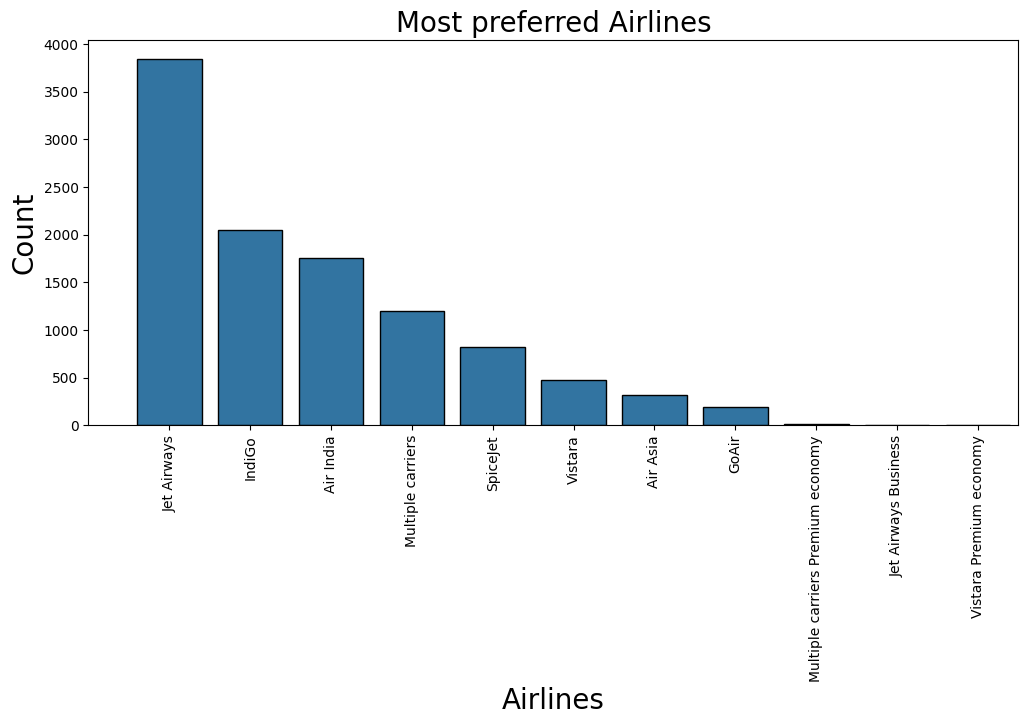

In [102]:
plt.figure(figsize=(12,5))
sns.countplot(x="Airline", data=Train_data,order = Train_data['Airline'].value_counts().index,ec = "black")
font_style={'family':'times new roman','size':20,'color':'black'}
plt.title("Most preferred Airlines",fontdict=font_style)
plt.ylabel("Count",fontdict=font_style)
plt.xlabel("Airlines",fontdict=font_style)
plt.xticks(rotation= 90)
plt.xlim(-1,10.5)
plt.show()

##### Insights
- Most preferred Airline is "Jet Airways"
- From all the total flight tickets sold, Jet Airways has the highest share followed by Indigo.

#### Airlines Vs Flight ticket Price


In [103]:
airlines = Train_data.groupby('Airline').Price.max()
airlines_df= airlines.to_frame().sort_values('Price',ascending=False)[0:10]
airlines_df

,Price
Airline,
Jet Airways Business,79512
Jet Airways,54826
Multiple carriers,36983
Air India,31945
SpiceJet,23267
GoAir,22794
IndiGo,22153
Vistara,21730
Multiple carriers Premium economy,14629


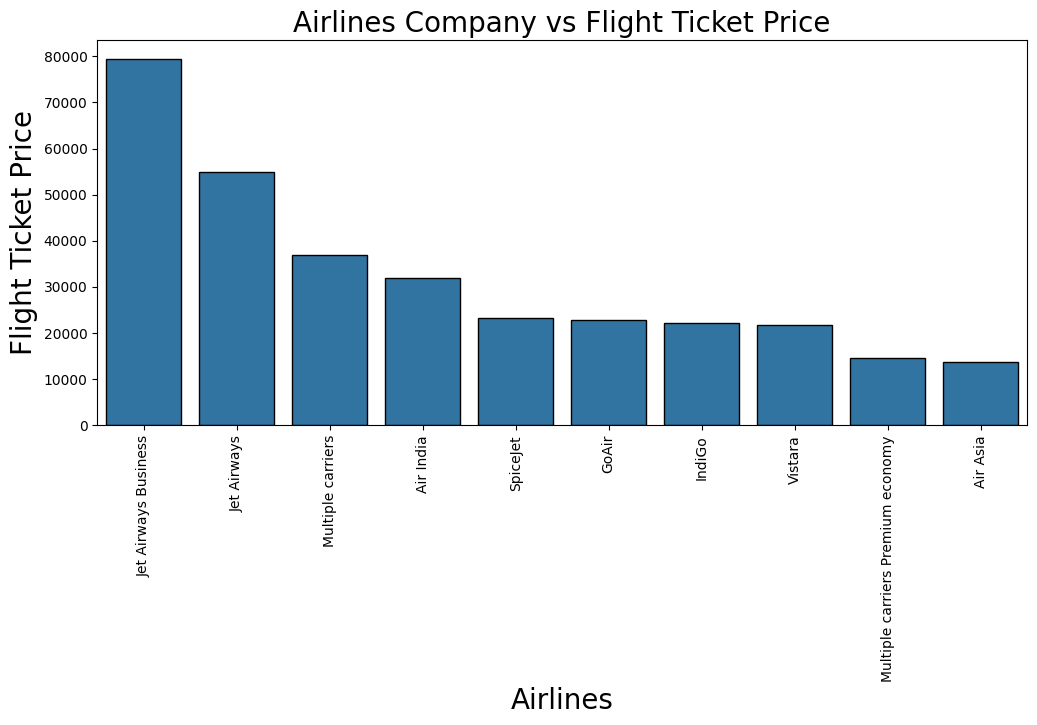

In [104]:
plt.subplots(figsize=(12,5))
sns.barplot(x=airlines_df.index, y=airlines_df["Price"],ec = "black")
font_style={'family':'times new roman','size':20,'color':'black'}
plt.title("Airlines Company vs Flight Ticket Price",fontdict=font_style )
plt.ylabel("Flight Ticket Price", fontdict=font_style)
plt.xlabel("Airlines", fontdict=font_style)
plt.xticks(rotation=90)
plt.show()

##### Insights
- "Jet Airways Business" tickets are the most expensive ones.

#### Price on Weekdays vs Weekends

In [105]:
days_df = Train_data[['Airline','Date_of_Journey', 'Price']].copy()
days_df.head()

,Airline,Date_of_Journey,Price
0,IndiGo,24/03/2019,3897
1,Air India,1/05/2019,7662
2,Jet Airways,9/06/2019,13882
3,IndiGo,12/05/2019,6218
4,IndiGo,01/03/2019,13302


In [106]:
days_df['Date_of_Journey'] = pd.to_datetime(days_df['Date_of_Journey'],format='%d/%m/%Y')
days_df['Weekday'] = days_df['Date_of_Journey'].dt.day_name()
days_df['Weekend'] = days_df['Weekday'].apply(lambda day: 1 if day == 'Sunday' else 0)
days_df.head()

,Airline,Date_of_Journey,Price,Weekday,Weekend
0,IndiGo,2019-03-24,3897,Sunday,1
1,Air India,2019-05-01,7662,Wednesday,0
2,Jet Airways,2019-06-09,13882,Sunday,1
3,IndiGo,2019-05-12,6218,Sunday,1
4,IndiGo,2019-03-01,13302,Friday,0


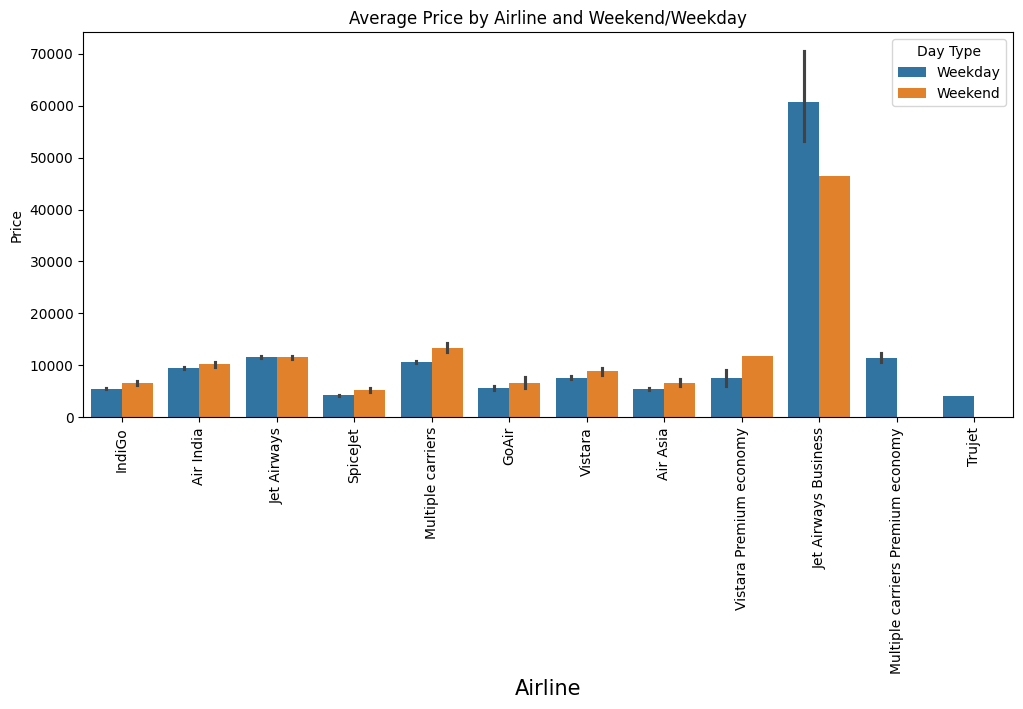

In [107]:
# Check and convert Weekend to categorical
if days_df['Weekend'].dtype != 'category':
    days_df['Weekend'] = days_df['Weekend'].map({0: 'Weekday', 1: 'Weekend'}).astype('category')

# Plotting
plt.subplots(figsize=(12, 5))
sns.barplot(data=days_df, x='Airline', y='Price', hue='Weekend')
plt.xlabel("Airline", size=15)
plt.xticks(rotation=90)
plt.title('Average Price by Airline and Weekend/Weekday')
plt.legend(title='Day Type')  # Optional
plt.show()


##### Insights
- The Price of tickets is higher on Weekends.

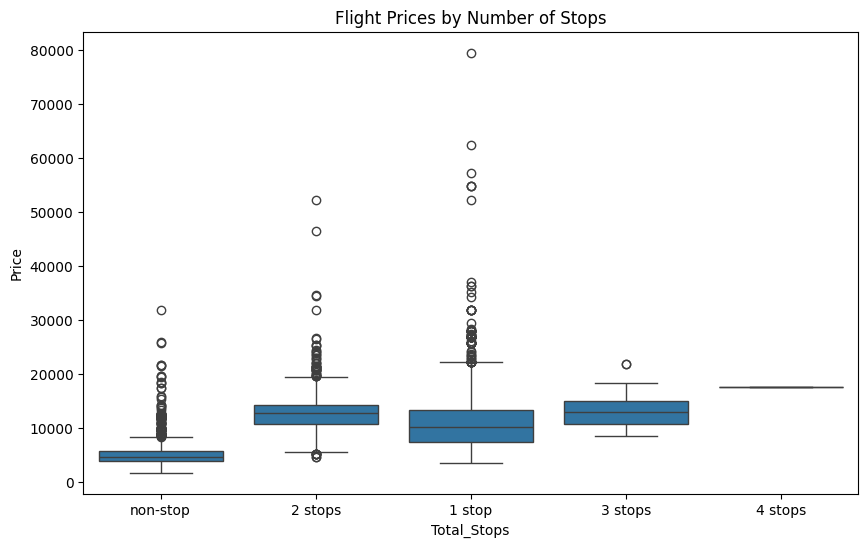

,Total_Stops,Mean_Price,Min_Price,Max_Price
0,1 stop,10594.123556,3480,79512
1,2 stops,12715.807895,4647,52285
2,3 stops,13112.000000,8607,21829
3,4 stops,17686.000000,17686,17686
4,non-stop,5024.900315,1759,31945


In [108]:
# Boxplot for Price by Total Stops
plt.figure(figsize=(10, 6))
sns.boxplot(data=Train_data, x='Total_Stops', y='Price')
plt.title('Flight Prices by Number of Stops')
plt.show()

# Creating a summary DataFrame
price_summary = Train_data.groupby('Total_Stops')['Price'].agg(['mean',  'min', 'max']).reset_index()
price_summary.columns = ['Total_Stops', 'Mean_Price', 'Min_Price', 'Max_Price']

# Display the summary DataFrame
price_summary


### Insights

- More stops, higher prices: The average price tends to increase as the number of stops increases,
- but non-stop flights remain the most economical option overall.

## Data Preprocessing

#### Data cleaning --> Outlier Detection

In [109]:
Q1 = Train_data['Price'].quantile(0.25)
Q3 = Train_data['Price'].quantile(0.75)
IQR = Q3 - Q1

# Determine outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = Train_data[(Train_data['Price'] < lower_bound) | (Train_data['Price'] > upper_bound)]
print("Outliers in Flight Prices:\n")
outliers

Outliers in Flight Prices:



,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
123,Air India,1/03/2019,Delhi,Cochin,DEL → BOM → COK,23:00,19:15 02 Mar,20h 15m,1 stop,No info,27430
396,Multiple carriers,1/03/2019,Delhi,Cochin,DEL → BOM → COK,12:50,19:15,6h 25m,1 stop,No info,36983
486,Jet Airways,01/03/2019,Banglore,New Delhi,BLR → BOM → DEL,08:55,15:15,6h 20m,1 stop,No info,26890
510,Jet Airways,01/03/2019,Banglore,New Delhi,BLR → BOM → DEL,07:00,12:25,5h 25m,1 stop,No info,26890
597,Air India,6/03/2019,Mumbai,Hyderabad,BOM → JDH → DEL → HYD,09:40,15:15 07 Mar,29h 35m,2 stops,No info,25139
...,...,...,...,...,...,...,...,...,...,...,...
10353,Jet Airways,6/03/2019,Mumbai,Hyderabad,BOM → BDQ → DEL → HYD,19:50,16:50 07 Mar,21h,2 stops,No info,24210
10364,Jet Airways Business,01/03/2019,Banglore,New Delhi,BLR → MAA → DEL,09:45,14:25,4h 40m,1 stop,Business class,57209
10383,Jet Airways,01/03/2019,Banglore,New Delhi,BLR → BOM → DEL,07:00,05:05 02 Mar,22h 5m,1 stop,No info,26890
10439,Jet Airways,01/03/2019,Banglore,New Delhi,BLR → BOM → DEL,18:40,09:00 02 Mar,14h 20m,1 stop,No info,31825


### Removing Outlier

In [110]:
# Remove outliers from the dataset
Train_data_cleaned = Train_data[~Train_data['Price'].isin(outliers['Price'])]


# Verify the shape of the new dataset
print("Original Data Shape:", Train_data.shape)
print("Cleaned Data Shape:", Train_data_cleaned.shape)


Original Data Shape: (10683, 11)
Cleaned Data Shape: (10589, 11)


## Check for duplicate rows

In [111]:
duplicate_rows = Train_data_cleaned[Train_data_cleaned.duplicated()]

# Display duplicate rows
print("Duplicate Rows:\n")
duplicate_rows


Duplicate Rows:



,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
683,Jet Airways,1/06/2019,Delhi,Cochin,DEL → NAG → BOM → COK,14:35,04:25 02 Jun,13h 50m,2 stops,No info,13376
1061,Air India,21/05/2019,Delhi,Cochin,DEL → GOI → BOM → COK,22:00,19:15 22 May,21h 15m,2 stops,No info,10231
1348,Air India,18/05/2019,Delhi,Cochin,DEL → HYD → BOM → COK,17:15,19:15 19 May,26h,2 stops,No info,12392
1418,Jet Airways,6/06/2019,Delhi,Cochin,DEL → JAI → BOM → COK,05:30,04:25 07 Jun,22h 55m,2 stops,In-flight meal not included,10368
1674,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,18:25,21:20,2h 55m,non-stop,No info,7303
...,...,...,...,...,...,...,...,...,...,...,...
10594,Jet Airways,27/06/2019,Delhi,Cochin,DEL → AMD → BOM → COK,23:05,12:35 28 Jun,13h 30m,2 stops,No info,12819
10616,Jet Airways,1/06/2019,Delhi,Cochin,DEL → JAI → BOM → COK,09:40,12:35 02 Jun,26h 55m,2 stops,No info,13014
10634,Jet Airways,6/06/2019,Delhi,Cochin,DEL → JAI → BOM → COK,09:40,12:35 07 Jun,26h 55m,2 stops,In-flight meal not included,11733
10672,Jet Airways,27/06/2019,Delhi,Cochin,DEL → AMD → BOM → COK,23:05,19:00 28 Jun,19h 55m,2 stops,In-flight meal not included,11150


In [112]:
#number of duplicate rows
print("Number of duplicate rows:", duplicate_rows.shape[0])

Number of duplicate rows: 220


In [113]:
# Keep only the first occurrence of duplicates
Train_data_cleaned = Train_data_cleaned.drop_duplicates(keep='first')

In [114]:
#after removing duplicate rows and outlier total number of rows
Train_data_cleaned.shape

(10369, 11)

### Feature Engineering on Train data

In [115]:
# Extact day, month, year from Date_of_Journey feature and store them in new columns.
Train_data_cleaned["Journey_date"]=Train_data_cleaned["Date_of_Journey"].str.split("/").str[0].astype(int)
Train_data_cleaned["Journey_month"]=Train_data_cleaned["Date_of_Journey"].str.split("/").str[1].astype(int)
Train_data_cleaned["Journey_year"]=Train_data_cleaned["Date_of_Journey"].str.split("/").str[2].astype(int)

In [116]:
Train_data_cleaned.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_date,Journey_month,Journey_year
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3,2019
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5,2019
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6,2019
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5,2019
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3,2019


In [117]:
# Now Date_of_Journey column is no longer required, so we can drop it.
Train_data_cleaned=Train_data_cleaned.drop(["Date_of_Journey"],axis=1)

In [118]:
Train_data_cleaned["Journey_year"].value_counts()

,count
Journey_year,
2019,10369


In [119]:
# Since Journey_year is the same ("2019") for all rows, we can drop it.
Train_data_cleaned=Train_data_cleaned.drop(["Journey_year"],axis=1)
Train_data_cleaned.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_date,Journey_month
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3


In [120]:
# Total_Stops
Train_data_cleaned["Total_Stops"]=Train_data_cleaned["Total_Stops"].str.split(" ").str[0]
Train_data_cleaned["Total_Stops"]=Train_data_cleaned["Total_Stops"].replace("non-stop","0")
Train_data_cleaned.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_date,Journey_month
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,0,No info,3897,24,3
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2,No info,7662,1,5
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2,No info,13882,9,6
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1,No info,6218,12,5
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1,No info,13302,1,3


In [121]:
# Total stops is object datatype till

In [122]:
# Extracting hours and min from Arrival time, Departure time
# Arrival_Time
Train_data_cleaned["Arrival_Time"]=Train_data_cleaned["Arrival_Time"].str.split(" ").str[0]
Train_data_cleaned['Arrival_hour']=Train_data_cleaned["Arrival_Time"].str.split(':').str[0].astype(int)
Train_data_cleaned['Arrival_min']=Train_data_cleaned["Arrival_Time"].str.split(':').str[1].astype(int)
Train_data_cleaned=Train_data_cleaned.drop(["Arrival_Time"],axis=1)

In [123]:
# Dep_Time
Train_data_cleaned['Dep_hour']=Train_data_cleaned["Dep_Time"].str.split(':').str[0].astype(int)
Train_data_cleaned['Dep_min']=Train_data_cleaned["Dep_Time"].str.split(':').str[1].astype(int)
Train_data_cleaned=Train_data_cleaned.drop(["Dep_Time"],axis=1)

Train_data_cleaned.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_date,Journey_month,Arrival_hour,Arrival_min,Dep_hour,Dep_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,0,No info,3897,24,3,1,10,22,20
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2,No info,7662,1,5,13,15,5,50
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2,No info,13882,9,6,4,25,9,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1,No info,6218,12,5,23,30,18,5
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1,No info,13302,1,3,21,35,16,50


#### Route column

- The route column tells about the journey's path.
- Route column can be removed because 'Total_Stops' field has already captured this value and both are related.

'Additional_Info' column can be dropped since more than 70% of them have no information.

In [124]:
Train_data_cleaned.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

#### Duration column
- Extract hours and min from Duration feature.
- Convert hours to min and find total duration in minutes to make it a single column.

In [125]:
#making column duration_hr
Train_data_cleaned["Duration_hr"]=Train_data_cleaned["Duration"].str.split(' ').str[0].str.split('h').str[0]

In [126]:
#construct column duration_min
Train_data_cleaned["Duration_min"]=Train_data_cleaned["Duration"].str.split(' ').str[1].str.split('m').str[0]

In [127]:
Train_data_cleaned.head()

,Airline,Source,Destination,Duration,Total_Stops,Price,Journey_date,Journey_month,Arrival_hour,Arrival_min,Dep_hour,Dep_min,Duration_hr,Duration_min
0,IndiGo,Banglore,New Delhi,2h 50m,0,3897,24,3,1,10,22,20,2,50
1,Air India,Kolkata,Banglore,7h 25m,2,7662,1,5,13,15,5,50,7,25
2,Jet Airways,Delhi,Cochin,19h,2,13882,9,6,4,25,9,25,19,NaN
3,IndiGo,Kolkata,Banglore,5h 25m,1,6218,12,5,23,30,18,5,5,25
4,IndiGo,Banglore,New Delhi,4h 45m,1,13302,1,3,21,35,16,50,4,45


In [128]:
print("no of null value in  duration min ",Train_data_cleaned['Duration_min'].isnull().sum())
#FILL IT WITH 0
Train_data_cleaned['Duration_min'].fillna("0",inplace=True)

no of null value in  duration min  1003


In [129]:
Train_data_cleaned[Train_data_cleaned['Duration_hr'].str.contains('m')]

,Airline,Source,Destination,Duration,Total_Stops,Price,Journey_date,Journey_month,Arrival_hour,Arrival_min,Dep_hour,Dep_min,Duration_hr,Duration_min
6474,Air India,Mumbai,Hyderabad,5m,2,17327,6,3,16,55,16,50,5m,0


In [130]:
#now we shift the minute value from  duration hour to  duration min
#replace the value of duration hour with 0

In [131]:
Train_data_cleaned.loc[[6474], 'Duration_min'] = Train_data_cleaned.loc[[6474], 'Duration_hr']
Train_data_cleaned.loc[Train_data_cleaned['Duration_min'] == '5m', 'Duration_min'] = 5
Train_data_cleaned["Duration_hr"]=Train_data_cleaned["Duration_hr"].replace("5m","0")

In [132]:
#now convert the duration hour and minute  datatype to integer
Train_data_cleaned["Duration_min"] = Train_data_cleaned["Duration_min"].astype(int)
Train_data_cleaned["Duration_hr"] = Train_data_cleaned["Duration_hr"].astype(int)

In [133]:
#create a new colum with the name of duaration
Train_data_cleaned["Duration"] = (Train_data_cleaned["Duration_hr"]*60) + Train_data_cleaned["Duration_min"]
Train_data_cleaned=Train_data_cleaned.drop(['Duration_hr','Duration_min'],axis=1)
Train_data_cleaned.head()

,Airline,Source,Destination,Duration,Total_Stops,Price,Journey_date,Journey_month,Arrival_hour,Arrival_min,Dep_hour,Dep_min
0,IndiGo,Banglore,New Delhi,170,0,3897,24,3,1,10,22,20
1,Air India,Kolkata,Banglore,445,2,7662,1,5,13,15,5,50
2,Jet Airways,Delhi,Cochin,1140,2,13882,9,6,4,25,9,25
3,IndiGo,Kolkata,Banglore,325,1,6218,12,5,23,30,18,5
4,IndiGo,Banglore,New Delhi,285,1,13302,1,3,21,35,16,50


### Checking for null values

In [134]:
Train_data_cleaned.isnull().sum()

,0
Airline,0
Source,0
Destination,0
Duration,0
Total_Stops,1
Price,0
Journey_date,0
Journey_month,0
Arrival_hour,0
Arrival_min,0


In [135]:
# filling Total_Stops
Train_data_cleaned["Total_Stops"].value_counts()

,count
Total_Stops,
1,5550
0,3472
2,1302
3,43
4,1


In [136]:
#all column convert to the correct form
Train_data_cleaned.dtypes

,0
Airline,object
Source,object
Destination,object
Duration,int64
Total_Stops,object
Price,int64
Journey_date,int64
Journey_month,int64
Arrival_hour,int64
Arrival_min,int64


In [137]:
# '1' is most frequently occuring value. So fill Total_Stops column null values by '1'
Train_data_cleaned["Total_Stops"]=Train_data_cleaned["Total_Stops"].fillna('1')

In [138]:
Train_data_cleaned["Total_Stops"]=Train_data_cleaned["Total_Stops"].astype(int)

In [139]:
Train_data_cleaned.isnull().sum()

,0
Airline,0
Source,0
Destination,0
Duration,0
Total_Stops,0
Price,0
Journey_date,0
Journey_month,0
Arrival_hour,0
Arrival_min,0


In [140]:
Train_data_cleaned.shape

(10369, 12)

### there is no null values now in the data set

### Using Encoding to Handle categorical data
##### Features with Categorical data
- Airline
- Source
- Destination

Apply Label Encoder to these features.

In [141]:
from sklearn.preprocessing import LabelEncoder
la=LabelEncoder()
for i in ["Airline","Source","Destination"]:
    Train_data_cleaned[i]=la.fit_transform(Train_data_cleaned[i])
Train_data_cleaned.head()

,Airline,Source,Destination,Duration,Total_Stops,Price,Journey_date,Journey_month,Arrival_hour,Arrival_min,Dep_hour,Dep_min
0,3,0,5,170,0,3897,24,3,1,10,22,20
1,1,3,0,445,2,7662,1,5,13,15,5,50
2,4,2,1,1140,2,13882,9,6,4,25,9,25
3,3,3,0,325,1,6218,12,5,23,30,18,5
4,3,0,5,285,1,13302,1,3,21,35,16,50


### Feature Selection

- Finding out the best feature which will contribute and have good relation with the target variable(Price).
- Let's use heat map to find correlation between features.

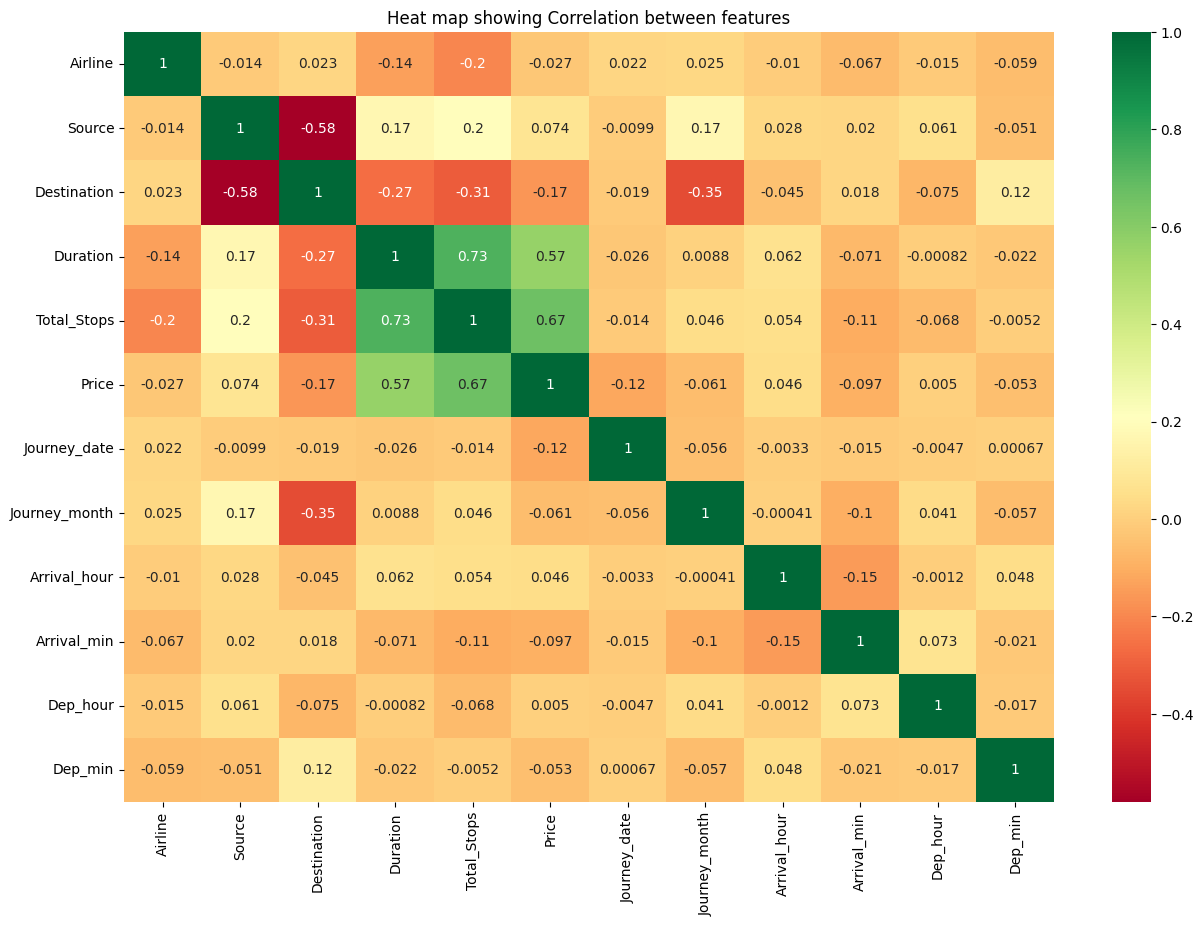

In [142]:
plt.figure(figsize=(15,10))

sns.heatmap(Train_data_cleaned.corr(),annot=True,cmap='RdYlGn')
plt.title("Heat map showing Correlation between features")

plt.show()

#### There is a high correlation between:
- Price & Total Stops
- Price & flight duration
- Duration & Total stops

#### now we prepare our test data which is given

### Loading the  Test Flight Fare Data
- Importing dataset
- Since data is in form of excel file we have to use pandas read_excel to load the data

In [143]:
Test_data=pd.read_excel("/content/Test_set.xlsx")
Test_data.shape

(2671, 10)

In [144]:
#as it i a test data there is no price column

### Summary of the dataset

In [145]:
Test_data.describe()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
count,2671,2671,2671,2671,2671,2671,2671,2671,2671,2671
unique,11,44,5,6,100,199,704,320,5,6
top,Jet Airways,9/05/2019,Delhi,Cochin,DEL → BOM → COK,10:00,19:00,2h 50m,1 stop,No info
freq,897,144,1145,1145,624,62,113,122,1431,2148


In [146]:
#information about the data, checking datatypes

Test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2671 non-null   object
 1   Date_of_Journey  2671 non-null   object
 2   Source           2671 non-null   object
 3   Destination      2671 non-null   object
 4   Route            2671 non-null   object
 5   Dep_Time         2671 non-null   object
 6   Arrival_Time     2671 non-null   object
 7   Duration         2671 non-null   object
 8   Total_Stops      2671 non-null   object
 9   Additional_Info  2671 non-null   object
dtypes: object(10)
memory usage: 208.8+ KB


## Dataset Overview
- Total Entries: 2671 (rows) and 10 features in test data
- Toatl entries in test data 2671
- Total Columns: 10
- Key Columns:
- Airline: Categorical
- Date_of_Journey: Object (to be converted to datetime)
- Source: Categorical
- Destination: Categorical
- Route: Object (1 missing value)
- Dep_Time: Object (to be converted to datetime)
- Arrival_Time: Object (to be converted to datetime)
- Duration: Object (to be cleaned and possibly converted)
- Total_Stops: Object (1 missing value)
- Additional_Info: Object
- Price has to predict
- Data Type Conversions Needed:
- Convert Date_of_Journey, Dep_Time, and Arrival_Time to appropriate datetime formats.
- Consider converting Total_Stops to numeric or categorical as needed.

## Feature Engineering on Test data

In [147]:
# Extact day, month, year from Date_of_Journey feature and store them in new columns.
Test_data["Journey_date"]=Test_data["Date_of_Journey"].str.split("/").str[0].astype(int)
Test_data["Journey_month"]=Test_data["Date_of_Journey"].str.split("/").str[1].astype(int)
Test_data["Journey_year"]=Test_data["Date_of_Journey"].str.split("/").str[2].astype(int)

In [148]:
Test_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Journey_date,Journey_month,Journey_year
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info,6,6,2019
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info,12,5,2019
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included,21,5,2019
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info,21,5,2019
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info,24,6,2019


In [149]:
# Now Date_of_Journey column is no longer required, so we can drop it.
Test_data=Test_data.drop(["Date_of_Journey"],axis=1)

In [150]:
Test_data["Journey_year"].value_counts()

,count
Journey_year,
2019,2671


In [151]:
#Since Journey_year is the same ("2019") for all rows, we can drop it.
Test_data=Test_data.drop(["Journey_year"],axis=1)
Test_data.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Journey_date,Journey_month
0,Jet Airways,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info,6,6
1,IndiGo,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info,12,5
2,Jet Airways,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included,21,5
3,Multiple carriers,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info,21,5
4,Air Asia,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info,24,6


In [152]:
# Total_Stops
Test_data["Total_Stops"]=Test_data["Total_Stops"].str.split(" ").str[0]
Test_data["Total_Stops"]=Test_data["Total_Stops"].replace("non-stop","0")
Test_data.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Journey_date,Journey_month
0,Jet Airways,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1,No info,6,6
1,IndiGo,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1,No info,12,5
2,Jet Airways,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1,In-flight meal not included,21,5
3,Multiple carriers,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1,No info,21,5
4,Air Asia,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,0,No info,24,6


In [153]:
# Total stops is object datatype till

In [154]:
# Extracting hours and min from Arrival time, Departure time
# Arrival_Time
Test_data["Arrival_Time"]=Test_data["Arrival_Time"].str.split(" ").str[0]
Test_data['Arrival_hour']=Test_data["Arrival_Time"].str.split(':').str[0].astype(int)
Test_data['Arrival_min']=Test_data["Arrival_Time"].str.split(':').str[1].astype(int)
Test_data=Test_data.drop(["Arrival_Time"],axis=1)

In [155]:
# Dep_Time
Test_data['Dep_hour']=Test_data["Dep_Time"].str.split(':').str[0].astype(int)
Test_data['Dep_min']=Test_data["Dep_Time"].str.split(':').str[1].astype(int)
Test_data=Test_data.drop(["Dep_Time"],axis=1)

Test_data.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Journey_date,Journey_month,Arrival_hour,Arrival_min,Dep_hour,Dep_min
0,Jet Airways,Delhi,Cochin,DEL → BOM → COK,10h 55m,1,No info,6,6,4,25,17,30
1,IndiGo,Kolkata,Banglore,CCU → MAA → BLR,4h,1,No info,12,5,10,20,6,20
2,Jet Airways,Delhi,Cochin,DEL → BOM → COK,23h 45m,1,In-flight meal not included,21,5,19,0,19,15
3,Multiple carriers,Delhi,Cochin,DEL → BOM → COK,13h,1,No info,21,5,21,0,8,0
4,Air Asia,Banglore,Delhi,BLR → DEL,2h 50m,0,No info,24,6,2,45,23,55


#### Route column

- The route column tells about the journey's path.
- Route column can be removed because 'Total_Stops' field has already captured this value and both are related.

'Additional_Info' column can be dropped since more than 70% of them have no information.

In [156]:
Test_data.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

#### Duration column
- Extract hours and min from Duration feature.
- Convert hours to min and find total duration in minutes to make it a single column.

In [157]:
#making column duration_hr
Test_data["Duration_hr"]=Test_data["Duration"].str.split(' ').str[0].str.split('h').str[0]

In [158]:
#construct column duration_min
Test_data["Duration_min"]=Test_data["Duration"].str.split(' ').str[1].str.split('m').str[0]

In [159]:
Test_data.head()

,Airline,Source,Destination,Duration,Total_Stops,Journey_date,Journey_month,Arrival_hour,Arrival_min,Dep_hour,Dep_min,Duration_hr,Duration_min
0,Jet Airways,Delhi,Cochin,10h 55m,1,6,6,4,25,17,30,10,55
1,IndiGo,Kolkata,Banglore,4h,1,12,5,10,20,6,20,4,NaN
2,Jet Airways,Delhi,Cochin,23h 45m,1,21,5,19,0,19,15,23,45
3,Multiple carriers,Delhi,Cochin,13h,1,21,5,21,0,8,0,13,NaN
4,Air Asia,Banglore,Delhi,2h 50m,0,24,6,2,45,23,55,2,50


In [160]:
print("no of null value in  duration min ",Test_data['Duration_min'].isnull().sum())
#FILL IT WITH 0
Test_data['Duration_min'].fillna("0",inplace=True)

no of null value in  duration min  254


In [161]:
Test_data[Test_data['Duration_hr'].str.contains('m')]

,Airline,Source,Destination,Duration,Total_Stops,Journey_date,Journey_month,Arrival_hour,Arrival_min,Dep_hour,Dep_min,Duration_hr,Duration_min
2660,Air India,Mumbai,Hyderabad,5m,2,12,3,16,55,16,50,5m,0


- now we shift the minute value from  duration hour to  duration min
- replace the value of duration hour with 0

In [162]:
Test_data.loc[[2660], 'Duration_min'] = Test_data.loc[[2660], 'Duration_hr']
Test_data.loc[Test_data['Duration_min'] == '5m', 'Duration_min'] = 5
Test_data["Duration_hr"]=Test_data["Duration_hr"].replace("5m","0")

In [163]:
#now convert the duration hour and minute  datatype to integer
Test_data["Duration_min"] = Test_data["Duration_min"].astype(int)
Test_data["Duration_hr"] = Test_data["Duration_hr"].astype(int)

In [164]:
#create a new colum with the name of duaration
Test_data["Duration"] = (Test_data["Duration_hr"]*60) + Test_data["Duration_min"]
Test_data=Test_data.drop(['Duration_hr','Duration_min'],axis=1)
Test_data.head()

,Airline,Source,Destination,Duration,Total_Stops,Journey_date,Journey_month,Arrival_hour,Arrival_min,Dep_hour,Dep_min
0,Jet Airways,Delhi,Cochin,655,1,6,6,4,25,17,30
1,IndiGo,Kolkata,Banglore,240,1,12,5,10,20,6,20
2,Jet Airways,Delhi,Cochin,1425,1,21,5,19,0,19,15
3,Multiple carriers,Delhi,Cochin,780,1,21,5,21,0,8,0
4,Air Asia,Banglore,Delhi,170,0,24,6,2,45,23,55


### Checking for null values test data


In [165]:
Test_data.isnull().sum()

,0
Airline,0
Source,0
Destination,0
Duration,0
Total_Stops,0
Journey_date,0
Journey_month,0
Arrival_hour,0
Arrival_min,0
Dep_hour,0


In [166]:
#all column convert to the correct form
Test_data.dtypes

,0
Airline,object
Source,object
Destination,object
Duration,int64
Total_Stops,object
Journey_date,int64
Journey_month,int64
Arrival_hour,int64
Arrival_min,int64
Dep_hour,int64


In [167]:
Test_data["Total_Stops"]=Test_data["Total_Stops"].astype(int)

In [168]:
Test_data.shape

(2671, 11)

In [169]:
Test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Airline        2671 non-null   object
 1   Source         2671 non-null   object
 2   Destination    2671 non-null   object
 3   Duration       2671 non-null   int64 
 4   Total_Stops    2671 non-null   int64 
 5   Journey_date   2671 non-null   int64 
 6   Journey_month  2671 non-null   int64 
 7   Arrival_hour   2671 non-null   int64 
 8   Arrival_min    2671 non-null   int64 
 9   Dep_hour       2671 non-null   int64 
 10  Dep_min        2671 non-null   int64 
dtypes: int64(8), object(3)
memory usage: 229.7+ KB


### Using Encoding to Handle categorical data
##### Features with Categorical data
- Airline
- Source
- Destination

Apply Label Encoder to these features.

In [170]:
from sklearn.preprocessing import LabelEncoder
la=LabelEncoder()
for i in ["Airline","Source","Destination"]:
    Test_data[i]=la.fit_transform(Test_data[i])
Test_data.head()

,Airline,Source,Destination,Duration,Total_Stops,Journey_date,Journey_month,Arrival_hour,Arrival_min,Dep_hour,Dep_min
0,4,2,1,655,1,6,6,4,25,17,30
1,3,3,0,240,1,12,5,10,20,6,20
2,4,2,1,1425,1,21,5,19,0,19,15
3,6,2,1,780,1,21,5,21,0,8,0
4,0,0,2,170,0,24,6,2,45,23,55


### Building Machine Learning models

For predicting the Price, we build 3 models using the following algorithms:
- Linear Regression
- Decision Tree regressor
- Random Forest Regressor

Compare the accuracies got from these 3 models and select the best model.
Apply hyperparameter tuning to increase its efficiency.
        

In [171]:
#splitting data into train and test dataframe
train_df=Train_data_cleaned

In [172]:
print(train_df.shape)
print(Test_data.shape)

(10369, 12)
(2671, 11)


In [173]:
#splitting data into x and y
x=train_df.drop(["Price"],axis=1)
y=train_df.loc[:,["Price"]].values

In [174]:
# spiliting the dataset into train data and test data
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=25)

#### Import models

In [175]:

# Create a DataFrame to store results
results = pd.DataFrame(columns=['Model', 'R² Score', 'MAE', 'MSE'])

In [176]:
# Function to train the models and evaluate
def predict(algorithm):
    print("Algorithm:", algorithm.__class__.__name__)  # Print the name of the algorithm
    model = algorithm.fit(x_train, y_train)  # Train the model
    y_pred = model.predict(x_test)  # Make predictions

    # Calculate metrics
    r2 = r2_score(y_test, y_pred)  # Calculate R² score
    mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
    mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
    results.loc[len(results)] = [algorithm.__class__.__name__, r2, mae, mse]

In [177]:
# Example usage of the function with different algorithms
algorithms = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    SVR(kernel='linear')  # Using linear kernel for SVR
]

### Scale the features ( standardization) fro svr

In [178]:
# Scale features for SVR
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [179]:
# Loop through the algorithms and make predictions
for algo in algorithms:
    if algo.__class__.__name__ == 'SVR':
        # Use the scaled features for SVR
        predict(algo.fit(x_train_scaled, y_train))
    else:
        predict(algo)

# Display the results DataFrame
print("\nModel Evaluation Results:")
results

Algorithm: LinearRegression
Algorithm: DecisionTreeRegressor
Algorithm: RandomForestRegressor
Algorithm: SVR

Model Evaluation Results:


,Model,R² Score,MAE,MSE
0,LinearRegression,0.514367,2258.828033,8.240088e+06
1,DecisionTreeRegressor,0.724637,1267.573853,4.672281e+06
2,RandomForestRegressor,0.819275,1110.037430,3.066485e+06
3,SVR,0.372396,2409.879454,1.064901e+07


The **Random Forest Regressor model** turned out to be the most accurate one out of the 3 models.

Let's try to improve the accuracy by doing Hyperparameter tuning.

### Hyperparameter tuning

#### Applying  Random Search to find the best parameters

In [180]:
from sklearn.model_selection import RandomizedSearchCV
random_search = {'n_estimators' : [100, 120, 150, 180, 200,220,250],
                 'max_features':['auto','sqrt'],
                 'max_depth':[5,10,15,20],
                 'min_samples_split' : [2, 5, 10, 15, 100],
                 'min_samples_leaf' : [1, 2, 5, 10]}
rf_regressor=RandomForestRegressor()
rf_model=RandomizedSearchCV(estimator=rf_regressor,param_distributions=random_search,
                            cv=3,n_jobs=-1,verbose=2,random_state=0)
rf_model.fit(x_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 120, 150, 180,
                                                         200, 220, 250]},
                   random_state=0, verbose=2)

In [181]:
# best parameter
rf_model.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 20}

In [182]:
#predicting the values
pred=rf_model.predict(x_test)
r2_score(y_test,pred)

0.8292833615557347

#### After hypertuning, the accuracy increases.

In [183]:
print('r2_score:',r2_score(y_test,pred))
print('MAE:', mean_absolute_error(y_test, pred))
print('MSE:', mean_squared_error(y_test, pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, pred)))

r2_score: 0.8292833615557347
MAE: 1183.7424464837823
MSE: 2896672.6007719873
RMSE: 1701.9613981439143


# For Random Forest Regressor,
- Before hyper tuning, R2 score = 81 %
- After hyper tuning, R2 score = 83 %


##  prediction on Test data

In [184]:
test_predictions = rf_model.predict(Test_data)
# As we have done same feature engineering

In [185]:
submission = pd.DataFrame({ 'Price': test_predictions})
submission.to_csv('submission.csv', index=False)

### save the model

In [186]:
from pickle import dump
dump(rf_model,open('flightfare.pkl','wb'))

##### Conclusion

We have used random forest regressor for training the model and improved its accuracy by doing hyperparameter tuning. As a result, we have trained our **Random Forest Regression model**, to forecast fares of flight tickets, with an R2 score of 83 %.